In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset & Dataloader

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
bs = 128
crop_size = 64 #CNN itu wajib ukurannya sama, makannya kita crop

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)), #scalenya 80% atau 100% dari gambar, supaya tetep dapet objectnya, jika objectnya bergeser
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

#data test itu kita gg melakukan augmentation
test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [5]:
#cek datanya, kita cek shapenya udh ke crop dengan baik apa ngga
image, label = next(iter(trainloader))
image.shape

torch.Size([128, 3, 64, 64])

In [6]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

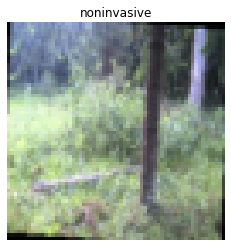

In [7]:
image, label = next(iter(trainloader))

# kalau mau ngeplot pastikan sudah di cpu dan format shape (h, w, c) dan harus taro dinumpy
# 1. harus di cpu
# 2. format harus (h, w, c)
# 3. harus di numpy dulu
img = image[0].cpu().permute(1, 2, 0).numpy()
plt.imshow(img)
plt.title(train_set.classes[label[0].item()])
plt.axis("off");

# Arsitektur dan Config

In [8]:
from jcopdl.layers import linear_block, conv_block

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8), # 8 x 32 x 32
            conv_block(8, 16), # 16 x 16 x 16
            conv_block(16, 32), # 32 x 8 x 8
            conv_block(32, 64), # 64 x 4 x 4 
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            linear_block(64 * 4 * 4, 256, dropout=0.1), #by default activation ReLu
            linear_block(256, 2, activation="lsoftmax")
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [10]:
config = set_config({
    "batch_size": bs,
    "crop_size": crop_size, #penting di simpan, supaya tau ukuran fix imagenya brp
    "model_dir": "model/cnn"
})

# MCOC

In [11]:
model = CNN().to(device)
criterion = nn.NLLLoss() #karena kita activationnya "lsoftmax"
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir=config.model_dir)

# Training


Epoch     1
Train_cost  = 0.6892 | Test_cost  = 0.6794 | Train_score = 0.5210 | Test_score = 0.5000 |

Epoch     2
Train_cost  = 0.6579 | Test_cost  = 0.6017 | Train_score = 0.6290 | Test_score = 0.7000 |

Epoch     3
Train_cost  = 0.5809 | Test_cost  = 0.5171 | Train_score = 0.7220 | Test_score = 0.7725 |

Epoch     4
Train_cost  = 0.5330 | Test_cost  = 0.5208 | Train_score = 0.7450 | Test_score = 0.7025 |
==> EarlyStop patience =  1 | Best test_score: 0.7725

Epoch     5
Train_cost  = 0.5093 | Test_cost  = 0.4577 | Train_score = 0.7510 | Test_score = 0.7975 |

Epoch     6
Train_cost  = 0.4662 | Test_cost  = 0.4401 | Train_score = 0.7810 | Test_score = 0.8100 |

Epoch     7
Train_cost  = 0.4704 | Test_cost  = 0.4410 | Train_score = 0.7820 | Test_score = 0.7900 |
==> EarlyStop patience =  1 | Best test_score: 0.8100

Epoch     8
Train_cost  = 0.4366 | Test_cost  = 0.4164 | Train_score = 0.7980 | Test_score = 0.8150 |

Epoch     9
Train_cost  = 0.4169 | Test_cost  = 0.3871 | Train_scor

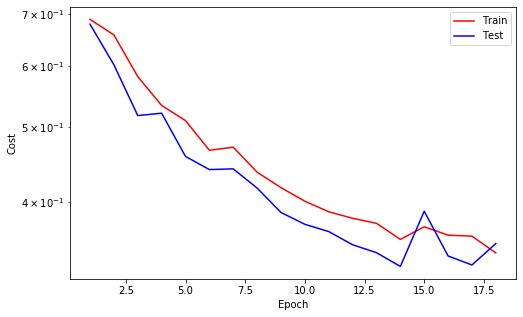

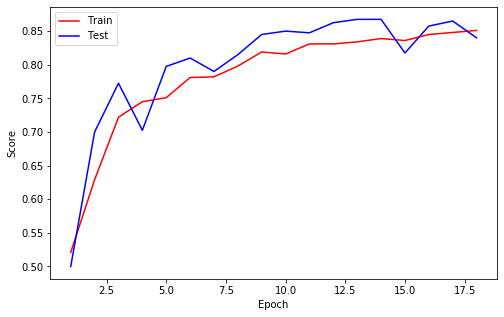

In [12]:
while True:
     model.train() #inisialisasi, ada saatnya droputnya dimatiin, karena balik lagi biar trainingnya menyebar
     cost = correct = 0
     for images, labels in trainloader:
         images, labels = images.to(device), labels.to(device)
        
         output = model(images)
         loss = criterion(output, labels)
         loss.backward()

         optimizer.step()
         optimizer.zero_grad()
        
         cost += loss.item()*images.shape[0]
         correct += (output.argmax(1) == labels).sum().item()
     train_cost = cost/len(train_set)
     train_score = correct/len(train_set)
    
     with torch.no_grad():
         model.eval()
         cost = correct = 0
         for images, labels in testloader:
             images, labels = images.to(device), labels.to(device)
        
             output = model(images)
             loss = criterion(output, labels)
            
             cost += loss.item()*images.shape[0]
             correct += (output.argmax(1) == labels).sum().item()
         test_cost = cost/len(test_set)
         test_score = correct/len(test_set)

     # Logging
     callback.log(train_cost, test_cost, train_score, test_score)

     # Checkpoint
     callback.save_checkpoint()
        
     # Runtime Plotting
     callback.cost_runtime_plotting()
     callback.score_runtime_plotting()
    
     # Early Stopping
     if callback.early_stopping(model, monitor="test_score"):
         callback.plot_cost()
         callback.plot_score()
         break

# Load Best Model

In [13]:
weights = torch.load(f"{config.model_dir}/weights_best.pth", map_location="cpu")
model.load_state_dict(weights)
model = model.to(device);

# Predict

In [14]:
images, labels = next(iter(testloader))
images, labels = images.to(device), labels.to(device)

In [15]:
with torch.no_grad():
    model.eval()
    output = model(images)
    preds = output.argmax(1)
preds

tensor([0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 0])

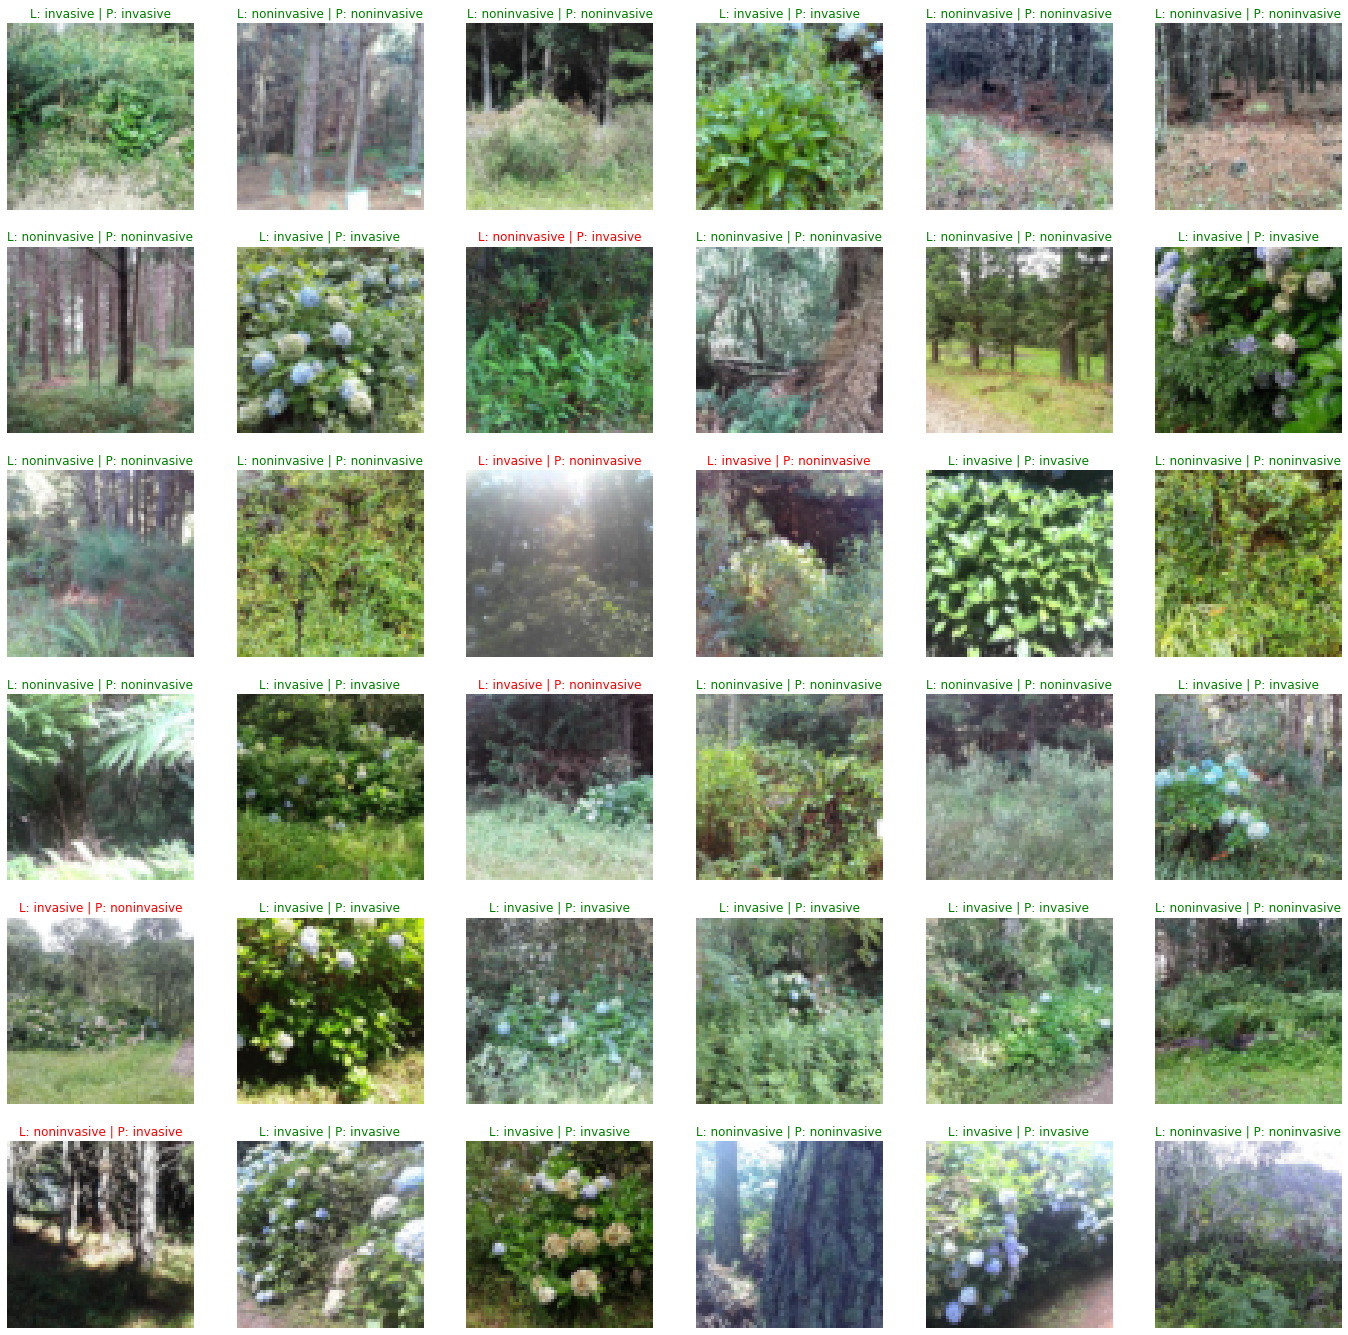

In [16]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for image, label, pred, ax in zip(images, labels, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color": 'r'} if label != pred else {"color": 'g'}        
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L: {label} | P: {pred}", fontdict=font);
    ax.axis('off');

model ini masih bisa diimprove dengan arsitektur yang lebih baik. Selain itu, sample ini hanya menggunakan 1/4 dari jumlah data aslinya sehingga dengan data yang lebih banyak masih kemungkinan model bisa lebih baik.